In [1]:
%load_ext autoreload
%autoreload 2
import pickle

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

# traigo mis funciones
import sys
sys.path.append('../../') #pongo los 2 puntos para que salga de la carpeta
import src.funciones as f
import src.soporte_prep as spp
import src.soporte_encoding as se
# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product
from itertools import combinations
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 

# Gestionar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from category_encoders import TargetEncoder

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_pickle('../../Datos_Mod3/df_estandarizado.pkl')

In [3]:
df.shape

(1568, 25)

In [4]:
df.head()

,Age_robust,Attrition,BusinessTravel,Department,DistanceFromHome_robust,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome_robust,NumCompaniesWorked_robust,PercentSalaryHike_robust,StockOptionLevel,TotalWorkingYears_robust,TrainingTimesLastYear,YearsAtCompany_robust,YearsSinceLastPromotion_robust,YearsWithCurrManager_robust,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,1.153846,0,Travel_Rarely,Sales,-0.083333,2,Life Sciences,Female,1,Healthcare Representative,Married,1.512817,-0.333333,-0.500000,0,-1.000000,6,-0.666667,-0.333333,-0.6,3.0,4.0,2.0,3,3
1,-0.384615,1,Travel_Frequently,Research & Development,0.250000,1,Life Sciences,Female,1,Research Scientist,Single,-0.130517,-0.666667,1.500000,1,-0.444444,3,0.000000,0.000000,0.2,3.0,2.0,4.0,2,4
2,-0.307692,0,Travel_Frequently,Research & Development,0.833333,4,Other,Male,4,Sales Executive,Married,2.656358,-0.333333,0.166667,3,-0.555556,2,0.000000,-0.333333,0.0,2.0,2.0,1.0,3,3
3,0.153846,0,Non-Travel,Research & Development,-0.416667,5,Life Sciences,Male,3,Human Resources,Married,0.630126,0.333333,-0.500000,3,0.333333,5,0.500000,2.000000,0.4,4.0,4.0,3.0,2,3
4,-0.307692,0,Travel_Rarely,Research & Development,0.250000,1,Medical,Male,1,Sales Executive,Single,-0.470523,0.666667,-0.333333,2,-0.111111,2,0.166667,-0.333333,0.2,4.0,1.0,3.0,3,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1568 entries, 0 to 1572
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Age_robust                      1568 non-null   float64 
 1   Attrition                       1568 non-null   int64   
 2   BusinessTravel                  1568 non-null   object  
 3   Department                      1568 non-null   object  
 4   DistanceFromHome_robust         1568 non-null   float64 
 5   Education                       1568 non-null   category
 6   EducationField                  1568 non-null   object  
 7   Gender                          1568 non-null   object  
 8   JobLevel                        1568 non-null   category
 9   JobRole                         1568 non-null   object  
 10  MaritalStatus                   1568 non-null   object  
 11  MonthlyIncome_robust            1568 non-null   float64 
 12  NumCompaniesWorked_robust

In [6]:
lista_col_cat = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [7]:
lista_col_num = df.select_dtypes(include=[int, float]).columns.tolist()

In [8]:
len(lista_col_cat)

15

In [9]:
lista_col_cat

['BusinessTravel',
 'Department',
 'Education',
 'EducationField',
 'Gender',
 'JobLevel',
 'JobRole',
 'MaritalStatus',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance',
 'JobInvolvement',
 'PerformanceRating']

In [10]:
len(lista_col_num)

10

In [11]:
lista_col_num

['Age_robust',
 'Attrition',
 'DistanceFromHome_robust',
 'MonthlyIncome_robust',
 'NumCompaniesWorked_robust',
 'PercentSalaryHike_robust',
 'TotalWorkingYears_robust',
 'YearsAtCompany_robust',
 'YearsSinceLastPromotion_robust',
 'YearsWithCurrManager_robust']

In [12]:
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].astype(str)
df['JobSatisfaction'] = df['JobSatisfaction'].astype(str)
df['WorkLifeBalance'] = df['WorkLifeBalance'].astype(str)

In [13]:
lista_ord, lista_des = f.detectar_orden_cat(df, lista_cat=df.select_dtypes(include=['object', 'category']), var_respuesta='Attrition')

Estamos evaluando la variable BUSINESSTRAVEL


Attrition,0,1
BusinessTravel,,
Non-Travel,145,12
Travel_Frequently,219,77
Travel_Rarely,952,163


Sí tiene orden la variable BusinessTravel
Estamos evaluando la variable DEPARTMENT


Attrition,0,1
Department,,
Human Resources,44,22
Research & Development,865,160
Sales,407,70


Sí tiene orden la variable Department
Estamos evaluando la variable EDUCATION


Attrition,0,1
Education,,
1,154,27
2,246,57
3,516,96
4,356,64
5,44,8


La variable Education no tiene orden
Estamos evaluando la variable EDUCATIONFIELD


Attrition,0,1
EducationField,,
Human Resources,16,12
Life Sciences,544,108
Marketing,141,26
Medical,406,81
Other,80,10
Technical Degree,129,15


Sí tiene orden la variable EducationField
Estamos evaluando la variable GENDER


Attrition,0,1
Gender,,
Female,523,95
Male,793,157


La variable Gender no tiene orden
Estamos evaluando la variable JOBLEVEL


Attrition,0,1
JobLevel,,
1,500,87
2,464,104
3,197,32
4,93,17
5,62,12


La variable JobLevel no tiene orden
Estamos evaluando la variable JOBROLE


Attrition,0,1
JobRole,,
Healthcare Representative,124,21
Human Resources,47,7
Laboratory Technician,232,46
Manager,90,16
Manufacturing Director,141,16
Research Director,63,22
Research Scientist,252,54
Sales Executive,288,58
Sales Representative,79,12


La variable JobRole no tiene orden
Estamos evaluando la variable MARITALSTATUS


Attrition,0,1
MaritalStatus,,
Divorced,319,37
Married,633,85
Single,364,130


Sí tiene orden la variable MaritalStatus
Estamos evaluando la variable STOCKOPTIONLEVEL


Attrition,0,1
StockOptionLevel,,
0,563,112
1,541,97
2,138,28
3,74,15


La variable StockOptionLevel no tiene orden
Estamos evaluando la variable TRAININGTIMESLASTYEAR


Attrition,0,1
TrainingTimesLastYear,,
0,45,10
1,64,11
2,485,103
3,428,90
4,116,17
5,112,17
6,66,4


La variable TrainingTimesLastYear no tiene orden
Estamos evaluando la variable ENVIRONMENTSATISFACTION


Attrition,0,1
EnvironmentSatisfaction,,
1.0,225,74
2.0,257,45
3.0,415,67
4.0,400,62
Desconocido,19,4


Sí tiene orden la variable EnvironmentSatisfaction
Estamos evaluando la variable JOBSATISFACTION


Attrition,0,1
JobSatisfaction,,
1.0,231,69
2.0,245,49
3.0,389,78
4.0,434,55
Desconocido,17,1


Sí tiene orden la variable JobSatisfaction
Estamos evaluando la variable WORKLIFEBALANCE


Attrition,0,1
WorkLifeBalance,,
1.0,56,27
2.0,296,61
3.0,805,132
4.0,128,28
Desconocido,31,4


Sí tiene orden la variable WorkLifeBalance
Estamos evaluando la variable JOBINVOLVEMENT


Attrition,0,1
JobInvolvement,,
1,71,19
2,330,62
3,788,144
4,127,27


La variable JobInvolvement no tiene orden
Estamos evaluando la variable PERFORMANCERATING


Attrition,0,1
PerformanceRating,,
3,1120,210
4,196,42


La variable PerformanceRating no tiene orden


In [14]:
lista_ord

['BusinessTravel',
 'Department',
 'EducationField',
 'MaritalStatus',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance']

In [15]:
lista_des

['Education',
 'Gender',
 'JobLevel',
 'JobRole',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'JobInvolvement',
 'PerformanceRating']

In [16]:
diccionario_encoding = { "target": lista_ord, 
                        "onehot": lista_des} 
# En caso de que queramos aplicar el método solo a una columna
encoding = se.Encoding(df, variable_respuesta="Attrition", diccionario_encoding=diccionario_encoding)
df_resultado = encoding.one_hot_encoding()
df_resultado = encoding.target_encoding()

['BusinessTravel', 'Department', 'EducationField', 'MaritalStatus', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']


In [17]:
df_resultado.head()

,Age_robust,Attrition,BusinessTravel,Department,DistanceFromHome_robust,EducationField,MaritalStatus,MonthlyIncome_robust,NumCompaniesWorked_robust,PercentSalaryHike_robust,TotalWorkingYears_robust,YearsAtCompany_robust,YearsSinceLastPromotion_robust,YearsWithCurrManager_robust,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Education_1,Education_2,Education_3,Education_4,Education_5,Gender_Female,Gender_Male,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,TrainingTimesLastYear_0,TrainingTimesLastYear_1,TrainingTimesLastYear_2,TrainingTimesLastYear_3,TrainingTimesLastYear_4,TrainingTimesLastYear_5,TrainingTimesLastYear_6,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,PerformanceRating_3,PerformanceRating_4
0,1.153846,0,0.146188,0.146751,-0.083333,0.165644,0.118384,1.512817,-0.333333,-0.500000,-1.000000,-0.666667,-0.333333,-0.6,0.139004,0.112474,0.170868,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.384615,1,0.260135,0.156098,0.250000,0.165644,0.263158,-0.130517,-0.666667,1.500000,-0.444444,0.000000,0.000000,0.2,0.139004,0.166667,0.179487,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.307692,0,0.260135,0.156098,0.833333,0.111156,0.118384,2.656358,-0.333333,0.166667,-0.555556,0.000000,-0.333333,0.0,0.149007,0.166667,0.325000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.153846,0,0.076433,0.156098,-0.416667,0.165644,0.118384,0.630126,0.333333,-0.500000,0.333333,0.500000,2.000000,0.4,0.134199,0.112474,0.140875,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.307692,0,0.146188,0.156098,0.250000,0.166324,0.263158,-0.470523,0.666667,-0.333333,-0.111111,0.166667,-0.333333,0.2,0.134199,0.230000,0.140875,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [18]:
df_resultado.columns

Index(['Age_robust', 'Attrition', 'BusinessTravel', 'Department',
       'DistanceFromHome_robust', 'EducationField', 'MaritalStatus',
       'MonthlyIncome_robust', 'NumCompaniesWorked_robust',
       'PercentSalaryHike_robust', 'TotalWorkingYears_robust',
       'YearsAtCompany_robust', 'YearsSinceLastPromotion_robust',
       'YearsWithCurrManager_robust', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', 'Education_1', 'Education_2',
       'Education_3', 'Education_4', 'Education_5', 'Gender_Female',
       'Gender_Male', 'JobLevel_1', 'JobLevel_2', 'JobLevel_3', 'JobLevel_4',
       'JobLevel_5', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'StockOptionLevel_0', 'StockOptionLevel_1', 'StockOptionLevel_2',

In [19]:
df_resultado.to_pickle('../../Datos_Mod3/df_encoded.pkl')

## Balanceo

In [20]:
df_resultado['Attrition'].value_counts(normalize=True) * 100

Attrition
0    83.928571
1    16.071429
Name: proportion, dtype: float64

In [21]:
desbalanceo = spp.Desbalanceo(df_resultado,'Attrition')

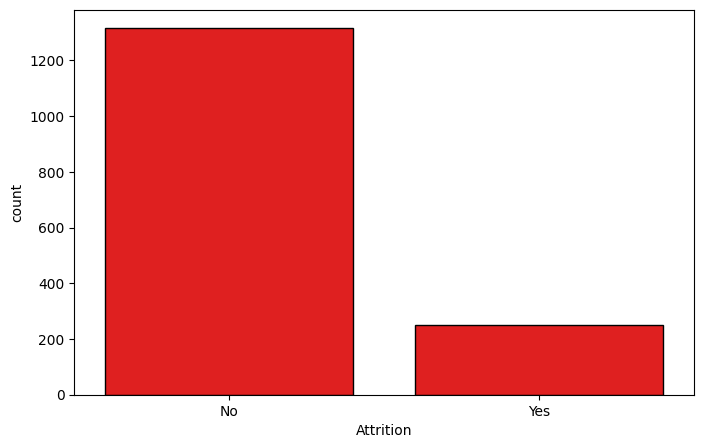

In [22]:
desbalanceo.visualizar_clase(color='red', edgecolor='black')

In [23]:
df_resultado.shape

(1568, 55)

## Tomek

In [24]:
df_tomek = desbalanceo.balancear_clases_tomek()

In [25]:
df_tomek.shape

(1510, 55)

## SmoteNC

In [26]:
balanceo = spp.Desbalanceo(df_tomek,'Attrition')

In [27]:
len(lista_col_num)

10

In [28]:
columnas_todas = df_tomek.columns

In [29]:
len(columnas_todas)

55

In [30]:
lista_categoricas = [col for col in columnas_todas if col not in lista_col_num]

In [31]:
df_balanceado = balanceo.balancear_clase_smotenc(lista_categoricas, sampling_strategy=0.8)

In [32]:
df_balanceado.shape

(2264, 55)

In [33]:
df_balanceado['Attrition'].value_counts(normalize=True) * 100

Attrition
0    55.565371
1    44.434629
Name: proportion, dtype: float64

<Axes: xlabel='Attrition', ylabel='count'>

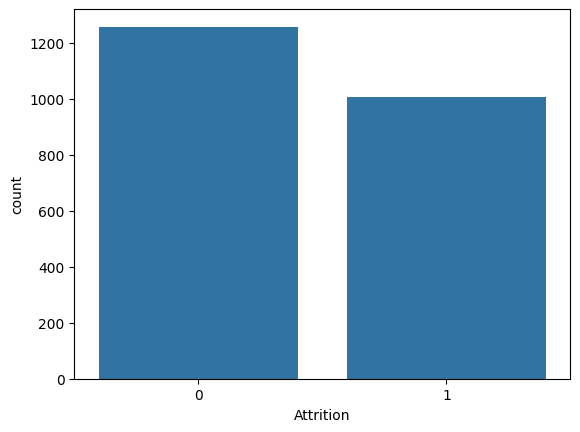

In [34]:
sns.countplot(x='Attrition', data=df_balanceado)

In [35]:
df_balanceado.to_pickle('../../Datos_Mod3/df_balanceado.pkl')